In [155]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [156]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [157]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

In [158]:
import matplotlib.pyplot as plt
import seaborn as sns

import os
import gc

from sklearn.model_selection import train_test_split


import tensorflow as tf
from tqdm.autonotebook import tqdm

import numpy as np #
import pandas as pd 

from keras import Sequential
from keras.callbacks import EarlyStopping

from keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.layers import Lambda, Input, GlobalAveragePooling2D,BatchNormalization
from keras.utils import to_categorical
# from keras import regularizers
from tensorflow.keras.models import Model


from keras.preprocessing.image import load_img
# from keras.preprocessing.image import img_to_array
# from keras.applications.imagenet_utils import decode_predictions

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [159]:
# Check for GPU
print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")
tf.config.list_physical_devices("GPU")

GPU available (YESS!!!!)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [160]:
#reading labels csv file

labels = pd.read_csv('/kaggle/input/dog-breed-identification/labels.csv')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [161]:
#describe
labels.describe()

,id,breed
count,10222,10222
unique,10222,120
top,9d33d4af3070c9676140336bf7bdca72,scottish_deerhound
freq,1,126


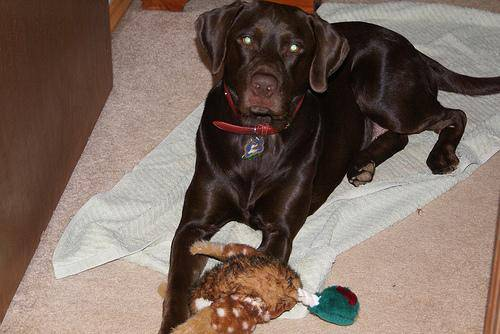

In [162]:
# Lets check one image
from IPython.display import display, Image
Image("../input/dog-breed-identification/train/43572ba7edf772a95f539e57afd9eb43.jpg")

In [163]:
import os
if len(os.listdir('/kaggle/input/dog-breed-identification/train/')) == len(labels['id']):
    print('Number of file matches number of actual images!')
else:
    print('Number of file doesnot matches number of actual images!!')

Number of file matches number of actual images!


In [164]:
#Create list of alphabetically sorted labels.
classes = sorted(list(set(labels['breed'])))
n_classes = len(classes)
print('Total unique breed {}'.format(n_classes))



#Map each label string to an integer label.
class_to_num = dict(zip(classes, range(n_classes)))
class_to_num

Total unique breed 120


{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

In [165]:
input_shape = (224,224,3)


def images_to_array(directory, label_dataframe, target_size = input_shape):
    
    image_labels = label_dataframe['breed']
    images = np.zeros([len(label_dataframe), target_size[0], target_size[1], target_size[2]],dtype=np.uint8) #as we have huge data and limited ram memory. uint8 takes less memory
    y = np.zeros([len(label_dataframe),1],dtype = np.uint8)
    
    for ix, image_name in enumerate(tqdm(label_dataframe['id'].values)):
        img_dir = os.path.join(directory, image_name + '.jpg')
        img = load_img(img_dir, target_size = target_size)
#         img = np.expand_dims(img, axis=0)
#         img = processed_image_resnet(img)
#         img = img/255
        images[ix]=img
#         images[ix] = img_to_array(img)
        del img
        
        dog_breed = image_labels[ix]
        y[ix] = class_to_num[dog_breed]
    
    y = to_categorical(y)
    
    return images,y

In [166]:
labels

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher


In [167]:
import time 
t = time.time()

X,y = images_to_array('/kaggle/input/dog-breed-identification/train', labels[:])

print('runtime in seconds: {}'.format(time.time() - t))

  0%|          | 0/10222 [00:00<?, ?it/s]

runtime in seconds: 46.54301333427429


In [ ]:
#length = len(X)
#length

In [ ]:
len(labels)

In [154]:
'''X= X[0:8000]
y=y[0:8000]
X_test=X[8001: length]
y_test= y[8001:length]
'''

'X= X[0:8000]\ny=y[0:8000]\nX_test=X[8001: length]\ny_test= y[8001:length]\n'

In [ ]:
#X_test[:][0]

In [168]:
classes[np.where(y[10] ==1)[0][0]]

'shetland_sheepdog'

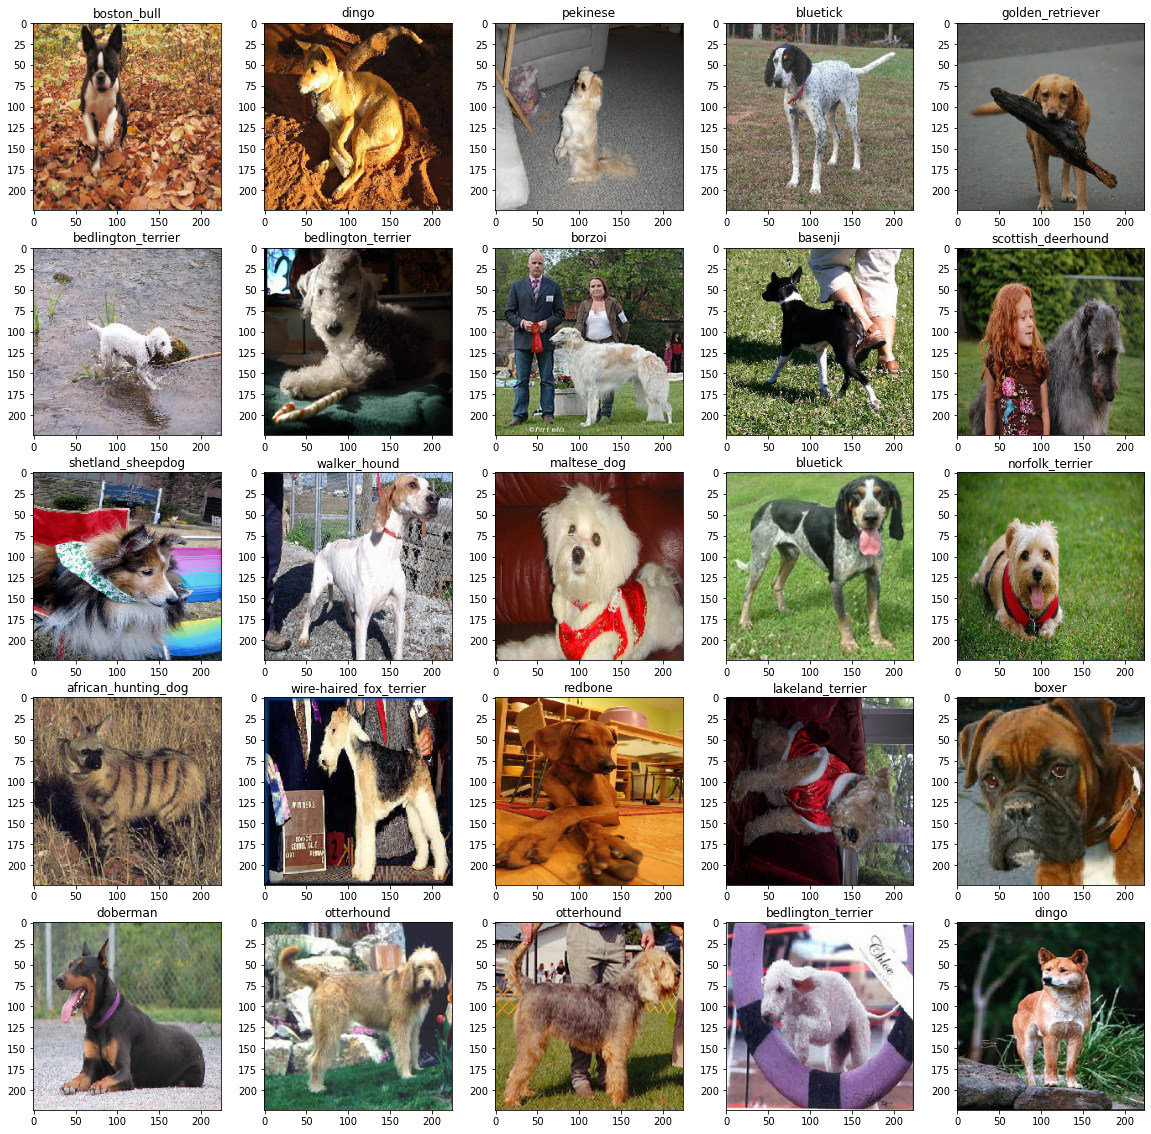

In [169]:
# lets check some dogs and their breeds
n=25

# setup the figure 
plt.figure(figsize=(20,20))

for i in range(n):
#     print(i)
    ax = plt.subplot(5, 5, i+1)
    plt.title(classes[np.where(y[i] ==1)[0][0]])
    plt.imshow(X[i].astype('int32')) # .astype('int32') ---> as imshow() needs integer data to read the image

ReduceLROnPlateau: Reduce learning rate when a metric has stopped improving.

In [170]:
#Learning Rate Annealer
lrr= ReduceLROnPlateau(monitor='val_acc', factor=.01, patience=3, min_lr=1e-5,verbose = 1)

#Prepare call backs
EarlyStop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [171]:
# Hyperparameters
batch_size= 128
epochs=50
learn_rate=.001
sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None,  amsgrad=False)

In [172]:
#function to extract features from the dataset by a given pretrained model
img_size = (224,224,3)

def get_features(model_name, model_preprocessor, input_size, data):

    input_layer = Input(input_size)
    preprocessor = Lambda(model_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False,
                            input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    
    #Extract feature.
    feature_maps = feature_extractor.predict(data, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps

In [173]:
from keras.applications.resnet50 import ResNet50,preprocess_input
resnet50_preprocessor = preprocess_input
resnet_features = get_features(ResNet50,
                                  resnet50_preprocessor,
                                  img_size  , X)


320/320 [==============================] - 17s 50ms/step
Feature maps shape:  (10222, 2048)


In [174]:
print('Final feature maps shape', resnet_features.shape)

Final feature maps shape (10222, 2048)


In [175]:
final_features=resnet_features

Epoch 1/50
64/64 [==============================] - 1s 6ms/step - loss: 4.6015 - accuracy: 0.1126 - val_loss: 1.5217 - val_accuracy: 0.6411
Epoch 2/50
64/64 [==============================] - 0s 4ms/step - loss: 1.9239 - accuracy: 0.4871 - val_loss: 1.0630 - val_accuracy: 0.7066
Epoch 3/50
64/64 [==============================] - 0s 4ms/step - loss: 1.4353 - accuracy: 0.5894 - val_loss: 0.9323 - val_accuracy: 0.7276
Epoch 4/50
64/64 [==============================] - 0s 4ms/step - loss: 1.1581 - accuracy: 0.6591 - val_loss: 0.8900 - val_accuracy: 0.7374
Epoch 5/50
64/64 [==============================] - 0s 4ms/step - loss: 1.0356 - accuracy: 0.6927 - val_loss: 0.8332 - val_accuracy: 0.7540
Epoch 6/50
64/64 [==============================] - 0s 7ms/step - loss: 0.9150 - accuracy: 0.7176 - val_loss: 0.8098 - val_accuracy: 0.7570
Epoch 7/50
64/64 [==============================] - 0s 6ms/step - loss: 0.8397 - accuracy: 0.7360 - val_loss: 0.7831 - val_accuracy: 0.7579
Epoch 8/50
64/64 [==

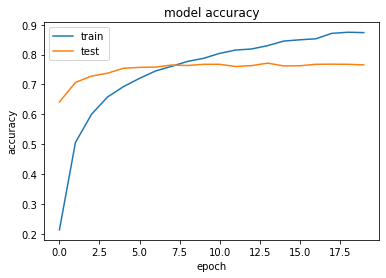

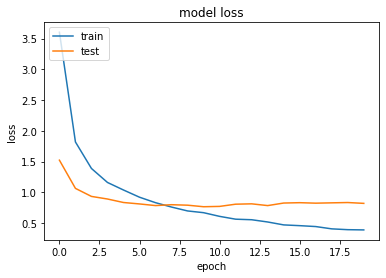

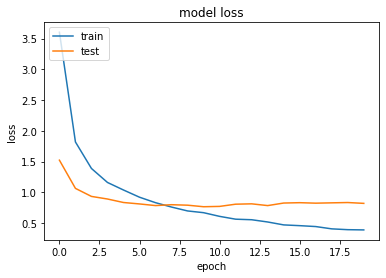

In [176]:
#Prepare Deep net

model = Sequential()
#model.add(Dense(1028,input_shape=(  final_features.shape[1],)))
model.add(Dense(1028, input_shape=(  final_features.shape[1], ), kernel_initializer = 'he_uniform', 
   kernel_regularizer = None, kernel_constraint = 'MaxNorm', activation = 'relu')) 
model.add(Dropout(0.7,input_shape=(final_features.shape[1],)))
model.add(Dense(n_classes,activation= 'softmax'))

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Training the model. 
history = model.fit(final_features, y,
            batch_size=batch_size,
            epochs=epochs,
            validation_split=0.2,
            callbacks=[lrr,EarlyStop])
'''f1_score= tfa.metrics.F1Score(
    num_classes: 120,
    average: str = None,
    threshold: Optional[FloatTensorLike] = None,
    name: str = 'f1_score',
    dtype: tfa.types.AcceptableDTypes = None
) '''

# Compile model
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
#history = model.fit(X, Y, validation_split=0.33, epochs=150, batch_size=10, verbose=0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



In [ ]:
#deleting to free up ram memory

#del inception_features
#del xception_features
#del nasnet_features
#del inc_resnet_features
del final_features
gc.collect()

In [177]:
#Function to read images from test directory

def images_to_array_test(test_path, img_size = (224,224,3)):
    test_filenames = [test_path + fname for fname in os.listdir(test_path)]

    data_size = len(test_filenames)
    images = np.zeros([data_size, img_size[0], img_size[1], 3], dtype=np.uint8)
    
    
    for ix,img_dir in enumerate(tqdm(test_filenames)):
#         img_dir = os.path.join(directory, image_name + '.jpg')
        img = load_img(img_dir, target_size = img_size)
#         img = np.expand_dims(img, axis=0)
#         img = processed_image_resnet(img)
#         img = img/255
        images[ix]=img
#         images[ix] = img_to_array(img)
        del img
    print('Ouptut Data Size: ', images.shape)
    return images

test_data = images_to_array_test('/kaggle/input/dog-breed-identification/test/', img_size)
#test_data = images_to_array_test(X_test,img_size)

  0%|          | 0/10357 [00:00<?, ?it/s]

Ouptut Data Size:  (10357, 224, 224, 3)


In [178]:
#Extract test data features.
def extact_features(data):
    resnet_features = get_features(ResNet50, resnet50_preprocessor, img_size, data)
    return resnet_features
    
test_features = extact_features(test_data)

324/324 [==============================] - 17s 50ms/step
Feature maps shape:  (10357, 2048)


In [179]:
print(test_features)

[[0.18633266 2.2622576  0.09252401 ... 0.05707368 0.2721018  0.19796187]
 [0.1023638  0.48170066 0.08791044 ... 0.7897784  0.40712774 0.46366993]
 [0.20805779 0.17193013 0.5861285  ... 0.19963877 0.45818028 0.49329644]
 ...
 [0.12181523 0.29769695 0.3892229  ... 0.         0.08705782 0.23588456]
 [0.9849467  2.348751   0.40019307 ... 1.078714   0.56793773 0.13865529]
 [0.52795076 0.02802552 0.04201958 ... 1.754102   0.14767617 0.19325891]]


In [ ]:
#Free up some space.
#del test_data
#gc.collect()

In [180]:
#Predict test labels given test data features.

pred = model.predict(test_features)

In [ ]:
pred

In [181]:
# First prediction
print(pred[0])
print(f"Max value (probability of prediction): {np.max(pred[0])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(pred[0])}") # because we used softmax activation in our model, this will be close to 1
print(f"Max index: {np.argmax(pred[0])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {classes[np.argmax(pred[0])]}")

[1.15571413e-06 1.04364473e-08 1.45922331e-06 8.38282631e-07
 6.60268515e-02 5.61632874e-07 2.97676820e-07 3.33122762e-06
 1.28189811e-06 2.25924737e-07 3.20679675e-07 1.83813853e-08
 8.97908770e-09 1.62747256e-08 1.83709687e-07 9.86539931e-07
 2.20258698e-07 2.37028507e-05 6.60165114e-08 5.17182401e-04
 6.15026181e-07 4.02017869e-03 6.96294592e-06 1.83351744e-07
 3.43411299e-09 6.06122667e-05 1.77634720e-05 3.05721696e-05
 7.94815378e-07 9.41548478e-06 2.11051763e-08 6.25379997e-08
 2.83097211e-06 4.02372422e-07 1.54210989e-06 1.56218988e-07
 1.81610091e-07 6.36784989e-07 3.56462152e-07 6.32420827e-09
 2.00207097e-07 1.42864849e-06 1.75668937e-08 3.21195853e-06
 5.12411361e-07 1.06495383e-04 9.26938739e-08 8.01785518e-06
 5.31582118e-05 3.75528364e-09 7.19469950e-09 1.63144805e-03
 1.09000666e-08 1.49262144e-06 2.23376773e-07 9.10162044e-08
 2.04603806e-10 3.92871954e-07 1.29961933e-07 1.22801828e-06
 1.76693120e-05 2.18173524e-09 1.98884891e-07 4.56166663e-06
 1.50816952e-04 2.544995

In [185]:
# Create pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(classes))
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [186]:
test_path = "/kaggle/input/dog-breed-identification/test/"
os.listdir(test_path)

['09e51e17e2b756ff2ace8a87bd1443fa.jpg',
 'f7a32505c12649183c5991ecfa7d68b3.jpg',
 'bc6d50ffb4644feb34530aa58943e85b.jpg',
 '7cbc041e79135a572aad87904b5c9c57.jpg',
 'f3b603f10d6a344f0395fb46b242ff8e.jpg',
 'db55098d859d27a3c05b0e3fc41d43e7.jpg',
 '665bab06a3ea861c0812c778486988e3.jpg',
 '7b57911ea7559cebd6db308125926642.jpg',
 'df0d6ba158287cb2b3ed6459a22d42ba.jpg',
 'b80d89ad4a17ac2537ff46d251efcd7c.jpg',
 '06ecb29a374579fb320c1c7d2801cbe1.jpg',
 'ac40a20790d53b782ee1484ff6e7d3f5.jpg',
 'c5ecd57f753cf97f996119a4d61d5d45.jpg',
 '47811a1b2ecb1427d13e78f6bf11ac0b.jpg',
 'db5e3239ade5b5a86cca91ad3efc1298.jpg',
 '83f291e4b5959368d95f74064ce9c3b7.jpg',
 '16a6150b6b5a84a2f0ee2c07f79125ff.jpg',
 'c998e2f910ca0aed211cd17e76acdc53.jpg',
 'fffbff22c1f51e3dc80c4bf04089545b.jpg',
 '192ecd8b7dfafe05b8059125628c9c26.jpg',
 'dccf2e91f79396055e7ff83f1f207fbc.jpg',
 'ad51422ba17bcd02d21af2c7df3af0ae.jpg',
 'f282ea683674bf3bde3715cb018b1c26.jpg',
 '62710340ee0ebace68f209f0070d9d2f.jpg',
 '0b297c77f3c031

In [187]:
# Append test image ID's to predictions DataFrame
test_path = "/kaggle/input/dog-breed-identification/test/"
preds_df["id"] = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,09e51e17e2b756ff2ace8a87bd1443fa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,f7a32505c12649183c5991ecfa7d68b3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,bc6d50ffb4644feb34530aa58943e85b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7cbc041e79135a572aad87904b5c9c57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,f3b603f10d6a344f0395fb46b242ff8e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
l= ['beagle', 'chihuahua', 'doberman','french_bulldog', 'golden_retriever', 'malamute', 'pug', 'saint_bernard', 'scottish_deerhound']

In [188]:
preds_df.loc[:,list(classes)]= pred

preds_df.to_csv('submission.csv',index=None)
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,09e51e17e2b756ff2ace8a87bd1443fa,1.15571e-06,1.04364e-08,1.45922e-06,8.38283e-07,0.0660269,5.61633e-07,2.97677e-07,3.33123e-06,1.2819e-06,...,5.15903e-07,1.05951e-06,9.10839e-08,7.99912e-07,1.75838e-06,5.81836e-09,1.06499e-06,0.000391183,8.56953e-07,3.65049e-07
1,f7a32505c12649183c5991ecfa7d68b3,2.60921e-08,1.24537e-06,3.25902e-08,2.30084e-06,3.2352e-05,1.19107e-06,2.10163e-06,7.3907e-05,0.000170122,...,4.27427e-07,5.53034e-07,0.00834727,8.84011e-06,3.40641e-06,4.16634e-07,2.7413e-08,1.78751e-05,1.00242e-07,2.02575e-07
2,bc6d50ffb4644feb34530aa58943e85b,2.50586e-06,0.00160983,1.27623e-05,3.59673e-06,2.28656e-06,5.85043e-07,6.48067e-08,1.54014e-07,3.7959e-06,...,3.30236e-05,3.00344e-08,3.23997e-08,6.78702e-07,3.87748e-07,7.41518e-06,3.95197e-08,6.56727e-06,1.5561e-07,7.85125e-07
3,7cbc041e79135a572aad87904b5c9c57,8.48145e-09,6.12495e-10,1.9355e-08,9.94572e-08,0.00188239,5.93243e-06,1.09617e-07,8.5665e-05,5.16386e-06,...,1.50421e-08,2.19357e-05,1.866e-06,8.39736e-06,0.023862,2.67021e-08,2.68979e-07,0.2003,4.78487e-06,3.70839e-09
4,f3b603f10d6a344f0395fb46b242ff8e,6.61538e-11,2.03916e-08,8.88602e-10,2.61215e-10,1.34528e-08,3.06454e-06,7.59749e-09,9.99987e-08,5.33673e-05,...,1.22898e-08,3.78607e-09,7.0141e-10,2.54263e-06,2.91747e-09,0.987692,1.82268e-08,4.06313e-08,4.00963e-08,9.89369e-10


In [189]:
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,09e51e17e2b756ff2ace8a87bd1443fa,1.15571e-06,1.04364e-08,1.45922e-06,8.38283e-07,0.0660269,5.61633e-07,2.97677e-07,3.33123e-06,1.2819e-06,...,5.15903e-07,1.05951e-06,9.10839e-08,7.99912e-07,1.75838e-06,5.81836e-09,1.06499e-06,0.000391183,8.56953e-07,3.65049e-07
1,f7a32505c12649183c5991ecfa7d68b3,2.60921e-08,1.24537e-06,3.25902e-08,2.30084e-06,3.2352e-05,1.19107e-06,2.10163e-06,7.3907e-05,0.000170122,...,4.27427e-07,5.53034e-07,0.00834727,8.84011e-06,3.40641e-06,4.16634e-07,2.7413e-08,1.78751e-05,1.00242e-07,2.02575e-07
2,bc6d50ffb4644feb34530aa58943e85b,2.50586e-06,0.00160983,1.27623e-05,3.59673e-06,2.28656e-06,5.85043e-07,6.48067e-08,1.54014e-07,3.7959e-06,...,3.30236e-05,3.00344e-08,3.23997e-08,6.78702e-07,3.87748e-07,7.41518e-06,3.95197e-08,6.56727e-06,1.5561e-07,7.85125e-07
3,7cbc041e79135a572aad87904b5c9c57,8.48145e-09,6.12495e-10,1.9355e-08,9.94572e-08,0.00188239,5.93243e-06,1.09617e-07,8.5665e-05,5.16386e-06,...,1.50421e-08,2.19357e-05,1.866e-06,8.39736e-06,0.023862,2.67021e-08,2.68979e-07,0.2003,4.78487e-06,3.70839e-09
4,f3b603f10d6a344f0395fb46b242ff8e,6.61538e-11,2.03916e-08,8.88602e-10,2.61215e-10,1.34528e-08,3.06454e-06,7.59749e-09,9.99987e-08,5.33673e-05,...,1.22898e-08,3.78607e-09,7.0141e-10,2.54263e-06,2.91747e-09,0.987692,1.82268e-08,4.06313e-08,4.00963e-08,9.89369e-10


Testing with custom input:

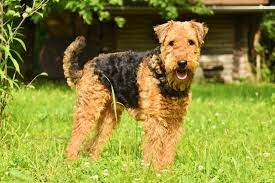

In [190]:
#Custom input

Image('../input/inputdogbreedidentification/download.jpg')

In [191]:
#reading the image and converting it into an np array

img_g = load_img('../input/inputdogbreedidentification/download.jpg',target_size = img_size)
img_g = np.expand_dims(img_g, axis=0) # as we trained our model in (row, img_height, img_width, img_rgb) format, np.expand_dims convert the image into this format
# img_g

In [192]:
img_g.shape

(1, 224, 224, 3)

In [193]:
# #Predict test labels given test data features.
test_features = extact_features(img_g)
predg = model.predict(test_features)
print(f"Predicted label: {classes[np.argmax(predg[0])]}")
print(f"Probability of prediction): {round(np.max(predg[0])) * 100} %")

1/1 [==============================] - 1s 786ms/step
Feature maps shape:  (1, 2048)
Predicted label: airedale
Probability of prediction): 100 %


In [194]:
#reading the image and converting it into an np array

img_g = load_img('../input/inputinputdogbreedidentification/a_t.jpg',target_size = img_size)
img_g = np.expand_dims(img_g, axis=0) # as we trained our model in (row, img_height, img_width, img_rgb) format, np.expand_dims convert the image into this format
# img_g

In [195]:
img_g.shape

(1, 224, 224, 3)

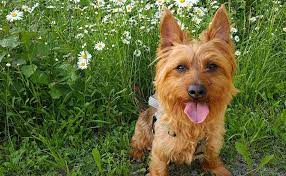

In [196]:
#Custom input

Image('../input/inputinputdogbreedidentification/a_t.jpg')

In [197]:
# #Predict test labels given test data features.
test_features = extact_features(img_g)
predg = model.predict(test_features)
print(f"Predicted label: {classes[np.argmax(predg[0])]}")
print(f"Probability of prediction): {(np.max(predg[0])) * 100} %")

print('---------')
index1 = classes.index('beagle')
index1
print(f"Predicted label: {classes[index1]}")
print(f"Probability of prediction): {((predg[0][index1])) * 100} %")

print('---------')
index2 = classes.index('chihuahua')
index2
print(f"Predicted label: {classes[index2]}")
print(f"Probability of prediction): {((predg[0][index2])) * 100} %")

print('---------')
index3 = classes.index('doberman')
index3
print(f"Predicted label: {classes[index3]}")
print(f"Probability of prediction): {((predg[0][index3])) * 100} %")

print('---------')
index3 = classes.index('french_bulldog')
index3
print(f"Predicted label: {classes[index3]}")
print(f"Probability of prediction): {((predg[0][index3])) * 100} %")

print('---------')
index3 = classes.index('golden_retriever')
index3
print(f"Predicted label: {classes[index3]}")
print(f"Probability of prediction): {((predg[0][index3])) * 100} %")

print('---------')
index3 = classes.index('malamute')
index3
print(f"Predicted label: {classes[index3]}")
print(f"Probability of prediction): {((predg[0][index3])) * 100} %")


print('---------')
index3 = classes.index('pug')
index3
print(f"Predicted label: {classes[index3]}")
print(f"Probability of prediction): {((predg[0][index3])) * 100} %")

print('---------')
index3 = classes.index('saint_bernard')
index3
print(f"Predicted label: {classes[index3]}")
print(f"Probability of prediction): {((predg[0][index3])) * 100} %")

print('---------')
index3 = classes.index('scottish_deerhound')
index3
print(f"Predicted label: {classes[index3]}")
print(f"Probability of prediction): {((predg[0][index3])) * 100} %")

print('---------')
index3 = classes.index('tibetan_mastiff')
index3
print(f"Predicted label: {classes[index3]}")
print(f"Probability of prediction): {((predg[0][index3])) * 100} %")









1/1 [==============================] - 1s 1s/step
Feature maps shape:  (1, 2048)
Predicted label: australian_terrier
Probability of prediction): 97.9640781879425 %
---------
Predicted label: beagle
Probability of prediction): 5.83850923163709e-07 %
---------
Predicted label: chihuahua
Probability of prediction): 0.00019623316802608315 %
---------
Predicted label: doberman
Probability of prediction): 0.0020850531655014493 %
---------
Predicted label: french_bulldog
Probability of prediction): 3.981931513408199e-05 %
---------
Predicted label: golden_retriever
Probability of prediction): 0.0022410013116314076 %
---------
Predicted label: malamute
Probability of prediction): 3.6792200397428587e-07 %
---------
Predicted label: pug
Probability of prediction): 1.641391883522303e-08 %
---------
Predicted label: saint_bernard
Probability of prediction): 4.85471496336487e-08 %
---------
Predicted label: scottish_deerhound
Probability of prediction): 2.3103063995222328e-05 %
---------
Predicted 